In [1]:
!pip install datasets
!pip install transformers
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import tqdm
import numpy as np
import torchvision
import math
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.utils as utils
import os
from glob import glob
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics

from torch.utils.data import Dataset, IterableDataset, DataLoader
import torchvision.transforms as transforms

import albumentations as A

import re

from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim) @ (Batch_Size, H, Dim, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output


In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)

        # (1, 320) -> (1, 1280)
        x = self.linear_1(x)

        # (1, 1280) -> (1, 1280)
        x = F.silu(x)

        # (1, 1280) -> (1, 1280)
        x = self.linear_2(x)

        return x

In [6]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time = 640):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(16, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(16, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 1280)

        residue = feature

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = self.groupnorm_feature(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = F.silu(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        feature = self.conv_feature(feature)

        # (1, 1280) -> (1, 1280)
        time = F.silu(time)

        # (1, 1280) -> (1, Out_Channels)
        time = self.linear_time(time)

        # Add width and height dimension to time.
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.groupnorm_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = F.silu(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.conv_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) + (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return self.residual_layer(residue)

In [7]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(16, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue_long = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x)

        n, c, h, w = x.shape

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2)

        # Normalization + Self-Attention with skip connection

        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_1(x)

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # Normalization + FFN with GeGLU and skip connection

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_3(x)

        # GeGLU as implemented in the original code: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/modules/attention.py#L37C10-L37C10
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)

        # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate)

        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long

In [8]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)


In [9]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

In [10]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([

            # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 16, Width / 16)
            SwitchSequential(nn.Conv2d(3, 80, kernel_size=3, stride=2, padding=1)),

            # (Batch_Size, 320, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(80, 80), UNET_AttentionBlock(8, 10)),

            # (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 32, Width / 32)
            SwitchSequential(nn.Conv2d(80, 160, kernel_size=3, stride=2, padding=1)),

            # (Batch_Size, 640, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(160, 160), UNET_AttentionBlock(8, 20)),

            # (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 64, Width / 64)
            SwitchSequential(nn.Conv2d(160, 320, kernel_size=3, stride=2, padding=1)),
        ])

        self.bottleneck = SwitchSequential(
        #     # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_ResidualBlock(320, 320),                   

        #     # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_AttentionBlock(8, 40),

        #     # (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64)
            UNET_ResidualBlock(320, 320),
        )

        self.decoders = nn.ModuleList([

            # (Batch_Size, 2560, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 64, Width / 64) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(640, 160), Upsample(160)),

            # (Batch_Size, 2560, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(320, 160), UNET_AttentionBlock(8, 20)),

            # (Batch_Size, 1920, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 32, Width / 32) -> (Batch_Size, 1280, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(320, 80), UNET_AttentionBlock(8, 10), Upsample(80)),

            # (Batch_Size, 1920, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(160, 80), UNET_AttentionBlock(8, 10)),

            # (Batch_Size, 960, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 16, Width / 16) -> (Batch_Size, 640, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(160, 80), UNET_AttentionBlock(8, 10), Upsample(80)),

        ])

    def forward(self, x, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, time)
            skip_connections.append(x)
        x = self.bottleneck(x, time)

        for layers in self.decoders:
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, time)

        return x

In [11]:
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(16, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (Batch_Size, 320, Height / 8, Width / 8)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = self.groupnorm(x)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 320, Height / 8, Width / 8)
        x = F.silu(x)

        # (Batch_Size, 320, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        x = self.conv(x)

        # (Batch_Size, 4, Height / 8, Width / 8)
        return x


In [12]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(160)
        self.unet = UNET()
        self.final = UNET_OutputLayer(80, 3)

    def forward(self, latent, time):
        # latent: (Batch_Size, 4, Height / 8, Width / 8)
        # time: (1, 320)

        # (1, 320) -> (1, 1280)
        time = self.time_embedding(time)

        # (Batch, 4, Height / 8, Width / 8) -> (Batch, 320, Height / 8, Width / 8)
        output = self.unet(latent, time)

        # (Batch, 320, Height / 8, Width / 8) -> (Batch, 4, Height / 8, Width / 8)
        output = self.final(output)

        # (Batch, 4, Height / 8, Width / 8)
        return output

In [13]:
def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=80, dtype=torch.float32) / 80)
    # Shape: (1, 160)
    x = torch.tensor(timestep, dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

In [14]:
def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x


In [15]:
class DDPMSampler:

    def __init__(self, num_training_steps=1000, beta_start: float = 0.00085, beta_end: float = 0.0120):
        # Params "beta_start" and "beta_end" taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L5C8-L5C8
        # For the naming conventions, refer to the DDPM paper (https://arxiv.org/pdf/2006.11239.pdf)
        self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype=torch.float32) ** 2
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)
        self.num_train_timesteps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - self.num_train_timesteps // self.num_inference_steps
        return prev_t

    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)

        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        # For t > 0, compute predicted variance βt (see formula (6) and (7) from https://arxiv.org/pdf/2006.11239.pdf)
        # and sample from it to get previous sample
        # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

        # we always take the log of variance, so clamp it to ensure it's not 0
        variance = torch.clamp(variance, min=1e-20)

        return variance

    def set_strength(self, strength=1):
        """
            Set how much noise to add to the input image.
            More noise (strength ~ 1) means that the output will be further from the input image.
            Less noise (strength ~ 0) means that the output will be closer to the input image.
        """
        # start_step is the number of noise levels to skip
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
        self.timesteps = self.timesteps[start_step:]
        self.start_step = start_step

    def step(self, timestep: int, reshaped_image: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self._get_previous_timestep(t)

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (15) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample = (reshaped_image - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 5. Compute predicted previous sample µ_t
        # See formula (7) from https://arxiv.org/pdf/2006.11239.pdf
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * reshaped_image

        # 6. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, device=device, dtype=model_output.dtype)
            # Compute the variance as per formula (7) from https://arxiv.org/pdf/2006.11239.pdf
            variance = (self._get_variance(t) ** 0.5) * noise

        # sample from N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # the variable "variance" is already multiplied by the noise N(0, 1)
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        # Sample from q(x_t | x_0) as in equation (4) of https://arxiv.org/pdf/2006.11239.pdf
        # Because N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # here mu = sqrt_alpha_prod * original_samples and sigma = sqrt_one_minus_alpha_prod
        noise = torch.randn(original_samples.shape, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples, noise

In [35]:
def generate(
    diffusion_model,
    n_inference_steps=50,
):
    with torch.no_grad():

        sampler = DDPMSampler()
        sampler.set_inference_timesteps(n_inference_steps)

        reshaped_image_shape = (1, 3, 64, 64)
        reshaped_image = torch.randn(reshaped_image_shape, device=device)

        diffusion_model.to(device)

        timesteps = sampler.timesteps
        for i, timestep in enumerate(timesteps):
            print(i)
            # (1, 320)
            time_embedding = get_time_embedding(torch.tensor(timestep).view(1,)).to(device)

            # (Batch_Size, 4, reshaped_image_Height, reshaped_image_Width)
            model_input = reshaped_image

            # model_output is the predicted noise
            # (Batch_Size, 4, reshaped_image_Height, reshaped_image_Width) -> (Batch_Size, 4, reshaped_image_Height, reshaped_image_Width)
            model_output = diffusion_model(model_input, time_embedding)

            # (Batch_Size, 4, reshaped_image_Height, reshaped_image_Width) -> (Batch_Size, 4, reshaped_image_Height, reshaped_image_Width)
            reshaped_image = sampler.step(timestep, reshaped_image, model_output)

        image = rescale(reshaped_image, (-1, 1), (0, 255), clamp=True)
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        image = image.permute(0, 2, 3, 1)
        image = image.to("cpu", torch.uint8).numpy()
        return image[0]

In [17]:
data_augmentation = transforms.Compose([transforms.RandomHorizontalFlip()])

def apply_data_augmentation(example):
    example["image"] = data_augmentation(example["image"])
    return example

In [18]:
dataset_name = "huggan/smithsonian_butterflies_subset"
train_dataset = load_dataset(dataset_name, split="train")
train_dataset = train_dataset.map(apply_data_augmentation)

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1000 [00:00<?, ?ex/s]

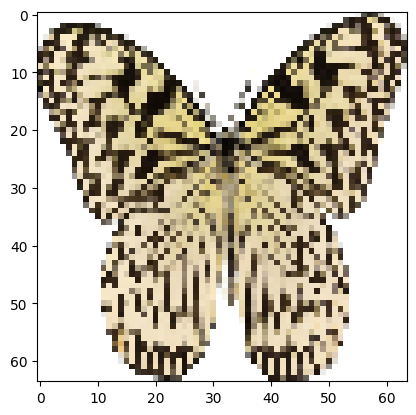

In [19]:
pix = next(iter(train_dataset))['image']
pix = np.array(pix)
pix = cv2.resize(pix, (64, 64), interpolation = cv2.INTER_LINEAR)
tensor = torch.tensor(pix, dtype= torch.float32)
tensor = tensor.view(64, 64, 3).to(torch.uint8)
image = tensor.numpy()
plt.imshow(image)

In [20]:
def custom_collate(batch):
  images = []
  prompts = []
  for item in batch:
      pix = np.array(item['image'])
      pix = cv2.resize(pix, (64, 64), interpolation = cv2.INTER_LINEAR)
      tensor = torch.tensor(pix, dtype = torch.float32)
      tensor = (tensor /255)
      tensor = tensor * 2
      
      tensor = tensor - 1 

      tensor = tensor.view(3, 64, 64)
      images.append(tensor)

  # Convert the images 
  images = torch.stack(images)
  return images


In [21]:
train_loader = DataLoader(train_dataset,batch_size=32,drop_last=True, collate_fn = custom_collate)

In [22]:
my_sampler = DDPMSampler()
diffusion_model = Diffusion().to(device)
optim = torch.optim.AdamW(diffusion_model.parameters())

In [23]:
def train_unet(model,sampler, train_loader, optimizer):
    losses = []
    model.train()
    for i, x in enumerate(train_loader):
        print(i + 1)
        x = x.to(device)  # GPU
        t = torch.randint(0, 1000, (32,)).long()
        time_embeddings = get_time_embedding(t).to(device)
        noisy_x, noise_added = sampler.add_noise(x, t)
        noisy_x = noisy_x.to(device)
        noise_added = noise_added.to(device)
        noise_pred = model(latent = noisy_x, time = time_embeddings)
        loss = nn.MSELoss()(noise_added, noise_pred) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

In [37]:
epochs = 100
train_losses = []

best_dict = None

optim = torch.optim.AdamW(diffusion_model.parameters())
for epoch in range(epochs):

    print('='*5 + f"Epoch {epoch + 1}" + '='*5)
    train_loss = train_unet(model= diffusion_model,sampler = my_sampler, train_loader= train_loader, optimizer= optim)
    best_dict = diffusion_model.state_dict()
    torch.save(best_dict, "modellol.tar")

    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1} - Train Loss {train_loss: .4f}")

=====Epoch 1=====
1
2


KeyboardInterrupt: 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


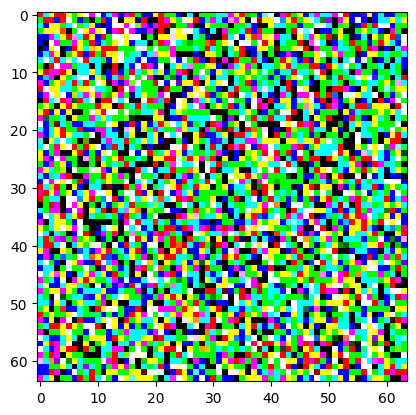

In [36]:
image = generate(diffusion_model)
plt.imshow(image)